In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/drive/My Drive/dsf/Project/data/MatrixFactorizationNew.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
!pip install lightfm

     |████████████████████████████████| 307kB 9.4MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=709149 sha256=2c599fdf62273ee3e62faab217ba8b9c890561fdb50c9ac62ffa621cc819d8d8
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [0]:
# import lightfm as lf

In [0]:
# !chmod -R 777 helpers.py

In [0]:
from lightfm import LightFM
import lightfm.evaluation
# import sys
# sys.path.append('./mode/')


## Helpers

In [0]:
import scipy.sparse as sp
import numpy as np


In [0]:
# helpers.threshold_interactions_df

In [0]:
def threshold_interactions_df(df, row_name, col_name, row_min, col_min):
    """Limit interactions df to minimum row and column interactions.
    Parameters
    ----------
    df : DataFrame
        DataFrame which contains a single row for each interaction between
        two entities. Typically, the two entities are a user and an item.
    row_name : str
        Name of column in df which corresponds to the eventual row in the
        interactions matrix.
    col_name : str
        Name of column in df which corresponds to the eventual column in the
        interactions matrix.
    row_min : int
        Minimum number of interactions that the row entity has had with
        distinct column entities.
    col_min : int
        Minimum number of interactions that the column entity has had with
        distinct row entities.
    Returns
    -------
    df : DataFrame
        Thresholded version of the input df. Order of rows is not preserved.
    Examples
    --------
    df looks like:
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
      1002  |  2002
    thus, row_name = 'user_id', and col_name = 'item_id'
    If we were to set row_min = 2 and col_min = 1, then the returned df would
    look like
    user_id | item_id
    =================
      1001  |  2002
      1001  |  2004
    """

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Starting interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of cols: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))

    done = False
    while not done:
        starting_shape = df.shape[0]
        col_counts = df.groupby(row_name)[col_name].count()
        df = df[~df[row_name].isin(col_counts[col_counts < col_min].index.tolist())]
        row_counts = df.groupby(col_name)[row_name].count()
        df = df[~df[col_name].isin(row_counts[row_counts < row_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True

    n_rows = df[row_name].unique().shape[0]
    n_cols = df[col_name].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_rows*n_cols) * 100
    print('Ending interactions info')
    print('Number of rows: {}'.format(n_rows))
    print('Number of columns: {}'.format(n_cols))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [0]:
def get_df_matrix_mappings(df, row_name, col_name):
    """Map entities in interactions df to row and column indices
    Parameters
    ----------
    df : DataFrame
        Interactions DataFrame.
    row_name : str
        Name of column in df which contains row entities.
    col_name : str
        Name of column in df which contains column entities.
    Returns
    -------
    rid_to_idx : dict
        Maps row ID's to the row index in the eventual interactions matrix.
    idx_to_rid : dict
        Reverse of rid_to_idx. Maps row index to row ID.
    cid_to_idx : dict
        Same as rid_to_idx but for column ID's
    idx_to_cid : dict
    """


    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid

    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid

    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def df_to_matrix(df, row_name, col_name):
    """Take interactions dataframe and convert to a sparse matrix
    Parameters
    ----------
    df : DataFrame
    row_name : str
    col_name : str
    Returns
    -------
    interactions : sparse csr matrix
    rid_to_idx : dict
    idx_to_rid : dict
    cid_to_idx : dict
    idx_to_cid : dict
    """

    rid_to_idx, idx_to_rid,\
        cid_to_idx, idx_to_cid = get_df_matrix_mappings(df,
                                                        row_name,
                                                        col_name)

    def map_ids(row, mapper):
        return mapper[row]

    I = df[row_name].apply(map_ids, args=[rid_to_idx]).as_matrix()
    J = df[col_name].apply(map_ids, args=[cid_to_idx]).as_matrix()
    V = np.ones(I.shape[0])
    interactions = sp.coo_matrix((V, (I, J)), dtype=np.float64)
    interactions = interactions.tocsr()
    return interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid


def train_test_split(interactions, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    Params
    ------
    interactions : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = interactions.copy().tocoo()
    test = sp.lil_matrix(train.shape)

    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0],
                replace=False,
                size=np.int64(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])

    train = train.tolil()

    for user in user_index:
        test_interactions = np.random.choice(interactions.getrow(user).indices,
                                        size=split_count,
                                        replace=False)
        train[user, test_interactions] = 0.
        # These are just 1.0 right now
        test[user, test_interactions] = interactions[user, test_interactions]


    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

## Matrix Creation


In [0]:
# df2 = df.drop(columns=['Unnamed: 0'])

In [0]:
# df = df2

In [14]:
df.head()

,Receipt Number,Date,Transaction Time,Customer Number,Loyalty ID,Store #,Store Name,Item Number,Item Description,Net Sales Units,Department Code,Department Name,Class Code,Class Name,Fineline Code,Fineline Name,Return Code
0,D70801,4/1/2017,7:02:55,290074,1926165091,O,15863 COPIAGUE,7158314,ACE FERT 4STEP 5M,1,70,"LAWN, GARDEN & FARM SUPPLIES",744,FERTILIZERS,74401,LAWN (DRY BAG),N
1,D70801,4/1/2017,7:02:55,290074,1926165091,O,15863 COPIAGUE,IS117235,7158314 $20 INST SAVINGS,-1,I1,ACE REWARDS INSTANT SAVINGS,IS1,ACE COUPON/CREDIT ITEMS,IS106,ACE COUPON/CREDIT ITEMS,N
2,A39683,4/1/2017,7:14:22,191376,1914355100,F,14822 NORTHPORT,78832,"ACE DECK NAIL16D3.5""ST1#",1,56,FASTENERS,574,PACKAGE NAILS,57403,1 & 5LB NAILS AND STAPLES,N
3,A39683,4/1/2017,7:14:22,191376,1914355100,F,14822 NORTHPORT,9269862,CMN Donations,1,DO,DONTATIONS,DON,DONATIONS,NaN,BLANK,N
4,D70802,4/1/2017,7:21:00,500851,1981639897,O,15863 COPIAGUE,1005412,CLEANR GLAS19OZ SPRAYWAY,2,10,CLEANING SUPPLIES,105,GLASS/PLASTIC CLEANERS,10504,GLASS CLEANER (AEROSOL),N


In [15]:
df.shape

(12205038, 17)

In [0]:
df = df[df['Return Code'] == 'N']

In [0]:
df.head()

,Receipt Number,Date,Transaction Time,Customer Number,Loyalty ID,Store #,Store Name,Item Number,Item Description,Net Sales Units,Department Code,Department Name,Class Code,Class Name,Fineline Code,Fineline Name,Return Code
0,D70801,4/1/2017,7:02:55,290074,1926165091,O,15863 COPIAGUE,7158314,ACE FERT 4STEP 5M,1,70,"LAWN, GARDEN & FARM SUPPLIES",744,FERTILIZERS,74401,LAWN (DRY BAG),N
1,D70801,4/1/2017,7:02:55,290074,1926165091,O,15863 COPIAGUE,IS117235,7158314 $20 INST SAVINGS,-1,I1,ACE REWARDS INSTANT SAVINGS,IS1,ACE COUPON/CREDIT ITEMS,IS106,ACE COUPON/CREDIT ITEMS,N
2,A39683,4/1/2017,7:14:22,191376,1914355100,F,14822 NORTHPORT,78832,"ACE DECK NAIL16D3.5""ST1#",1,56,FASTENERS,574,PACKAGE NAILS,57403,1 & 5LB NAILS AND STAPLES,N
3,A39683,4/1/2017,7:14:22,191376,1914355100,F,14822 NORTHPORT,9269862,CMN Donations,1,DO,DONTATIONS,DON,DONATIONS,NaN,BLANK,N
4,D70802,4/1/2017,7:21:00,500851,1981639897,O,15863 COPIAGUE,1005412,CLEANR GLAS19OZ SPRAYWAY,2,10,CLEANING SUPPLIES,105,GLASS/PLASTIC CLEANERS,10504,GLASS CLEANER (AEROSOL),N


In [0]:
df['Item Number'] = df['Item Number'].astype(str)

In [0]:
"Loyalty Id"
"Item Number"
"Item Description"

'Item Number'

In [0]:
df.columns

Index(['Customer Number', 'Receipt Number', 'Store #', 'Store Name',
       'Item Number', 'Item Description', 'Department Code', 'Department Name',
       'Class Code', 'Class Name', 'Fineline Code', 'Fineline Name',
       'Loyalty ID', 'DateTime'],
      dtype='object')

In [0]:
df['Loyalty ID'] = df['Loyalty ID'].astype(int)

In [0]:
inters = threshold_interactions_df(df,'Loyalty ID','Item Description', 60,120)

Starting interactions info
Number of rows: 348775
Number of cols: 100185
Sparsity: 0.034%
Ending interactions info
Number of rows: 8392
Number of columns: 7443
Sparsity: 2.656%


In [0]:
inters2 = threshold_interactions_df(df,'Loyalty ID','Item Description', 60,130)

Starting interactions info
Number of rows: 348775
Number of cols: 100185
Sparsity: 0.034%
Ending interactions info
Number of rows: 5862
Number of columns: 5993
Sparsity: 3.589%


In [0]:
inters = threshold_interactions_df(df,'Loyalty ID','Item Number', 5,5)

Starting interactions info
Number of rows: 348993
Number of cols: 105949
Sparsity: 0.033%
Ending interactions info
Number of rows: 274373
Number of columns: 69798
Sparsity: 0.062%


In [0]:
inters.head()

,Customer Number,Receipt Number,Store #,Store Name,Item Number,Item Description,Department Code,Department Name,Class Code,Class Name,Fineline Code,Fineline Name,Loyalty ID,DateTime
4,500851,D70802,O,15863 COPIAGUE,1005412,CLEANR GLAS19OZ SPRAYWAY,10,CLEANING SUPPLIES,105,GLASS/PLASTIC CLEANERS,10504,GLASS CLEANER (AEROSOL),1981639897,2017-04-01 07:21:00
7,901294,E84228,4,6910 FARMINGDALE,B028204,SUPERHIDE LAT FLAT CEILWHITE GL,14,PAINT & PAINT SUPPLIES,161,LIQUID PAINT- NATIONAL,2022,S-H FLAT 1 GAL 282,1981737279,2017-04-01 07:31:05
8,901294,E84228,4,6910 FARMINGDALE,B028400,SUPERHIDE LX PR/UN-WHITE GAL,14,PAINT & PAINT SUPPLIES,161,LIQUID PAINT- NATIONAL,2024,S-H PRIMER 1 GAL 284,1981737279,2017-04-01 07:31:05
12,4020,125558,4,6910 FARMINGDALE,1485747,"PAINTBRSH SLVRTP AS 3""",14,PAINT & PAINT SUPPLIES,131,PAINT BRUSHES,13105,FOAM,1981734896,2017-04-01 07:33:22
13,4020,125558,4,6910 FARMINGDALE,19988,"PNTBRSH XL DALE 2.5""",14,PAINT & PAINT SUPPLIES,131,PAINT BRUSHES,13109,PROFESSIONAL,1981734896,2017-04-01 07:33:22


In [0]:
inters.shape

(1077032, 14)

In [0]:
inters['Item Number'].nunique()

6216

In [0]:
inters['Item Description'].nunique()

5339

In [0]:
likes, cid_to_idx, idx_to_cid,\
pid_to_idx, idx_to_pid = df_to_matrix(inters, 'Loyalty ID', 'Item Description')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
np.max(likes[0:100]), np.min(likes[0:100])

(901.0, 0.0)

In [0]:
# idx_to_cid

In [0]:
len(pid_to_idx)

7443

In [0]:
train, test, user_index = train_test_split(likes, 60, fraction=0.2)

In [0]:
likes

<8392x7443 sparse matrix of type '<class 'numpy.float64'>'
	with 1024276 stored elements in Compressed Sparse Row format>

In [0]:
train

<8392x7443 sparse matrix of type '<class 'numpy.float64'>'
	with 923596 stored elements in Compressed Sparse Row format>

In [0]:
test

<8392x7443 sparse matrix of type '<class 'numpy.float64'>'
	with 100680 stored elements in Compressed Sparse Row format>

In [0]:
len(user_index)

1678

In [0]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))


In [0]:

eval_train = eval_train.tolil()


In [0]:
len(non_eval_users)

6714

In [0]:
eval_train[2, :]

<1x7443 sparse matrix of type '<class 'numpy.float64'>'
	with 385 stored elements in LInked List format>

In [0]:
cnt = 0
for u in non_eval_users:
    cnt+=1
    if cnt % 1000 == 0:
      print (cnt)
    eval_train[u, :] = 0

1000
2000
3000
4000
5000
6000


In [0]:
eval_train = eval_train.tocsr()

### TODO Pdt-Item Features incorporation 

In [0]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)


In [0]:

def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [0]:
def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
  
    train_patk = []
    test_patk = []
    headers = ['Dimension', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    more = 35
    for epoch in iterarray:
        model = LightFM(loss='warp', random_state=2019,no_components=epoch)
        model.fit(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return train_patk, test_patk

In [0]:
model = LightFM(loss='warp', random_state=2019,no_components=8)
# Initialize model.
model.fit(train, epochs=0);

iterarray = range(5, 45, 5)



In [0]:
model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

'''
+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     5      |  0.38939   |  0.23123   |
+------------+------------+------------+
|     10     |  0.40095   |  0.23421   |
+------------+------------+------------+
|     15     |  0.40048   |  0.23671   |
+------------+------------+------------+
|     20     |  0.40107   |  0.23731   |
+------------+------------+------------+
|     25     |  0.40536   |  0.23838   |
+------------+------------+------------+
|     30     |  0.40417   |  0.24064   |
+------------+------------+------------+
|     35     |  0.40298   |  0.24231   |
+------------+------------+------------+
|     40     |  0.40429   |  0.24136   |
+------------+------------+------------+
'''

+------------+------------+------------+
| Dimension  | train p@5  |  test p@5  |
+============+============+============+
|     5      |  0.39058   |  0.23206   |
+------------+------------+------------+
|     10     |  0.40477   |  0.24184   |
+------------+------------+------------+
|     15     |  0.41287   |  0.24041   |
+------------+------------+------------+
|     20     |  0.41383   |  0.23683   |
+------------+------------+------------+
|     25     |  0.41740   |  0.23278   |
+------------+------------+------------+
|     30     |  0.42646   |  0.22682   |
+------------+------------+------------+
|     35     |  0.42908   |  0.21847   |
+------------+------------+------------+
|     40     |  0.43004   |  0.22491   |
+------------+------------+------------+


ValueError: ignored

In [0]:
model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     5      |  0.34707   |  0.23579   |
+------------+------------+------------+
|     10     |  0.34534   |  0.23753   |
+------------+------------+------------+
|     15     |  0.34620   |  0.23341   |
+------------+------------+------------+
|     20     |  0.33536   |  0.22039   |
+------------+------------+------------+
|     25     |  0.33362   |  0.21866   |
+------------+------------+------------+


KeyboardInterrupt: ignored

In [0]:
pid_to_idx

{'CLEANR GLAS19OZ SPRAYWAY': 0,
 'SUPERHIDE LAT FLAT CEILWHITE  GL': 1,
 'SUPERHIDE LX PR/UN-WHITE GAL': 2,
 'PAINTBRSH SLVRTP AS 3"': 3,
 'PNTBRSH XL DALE 2.5"': 4,
 '15A21/LED/2700K/120V/4PK': 5,
 'POWERADE FRUIT PUNCH': 6,
 'CMN Donations': 7,
 'KEROSENE 1-K WC 1G JUG': 8,
 'BEN INT S-G BASE1 QT': 9,
 'BLADE SAWZAL 9" 5-8T PK5': 10,
 'NESTLE PURE LIFE 24PK.5L': 11,
 'SUPERHIDE EGGSHELLPASTEL BSE  GA': 12,
 'FASTENERS': 13,
 'REGAL AQUAGLO WHITE': 14,
 'REG SEL INT EGGSHL B1 GL': 15,
 'BIRD NUGGETS PEANUT FLAV': 16,
 '20# PREMIUM OIL SUNFLOWER': 17,
 '20# NUT AND BERRY BUDDIES': 18,
 'IN-STORE COUPON SAVE $5.00': 19,
 '50% OFF 1 ITEM UNDER $30': 20,
 '.5 MIL 9X12 DROP  5PK': 21,
 'TARP POLY BLUE/BRN 6X8': 22,
 'G-FORCE 10X12 BLUE TUFF TARPS': 23,
 'MSKG TAPE DEL 1.88x60': 24,
 'DUCT TAPE 60YDS GRAY ACE': 25,
 'PLSTC BUCKET 5G WHT ACE': 26,
 'CAULK DFLEX230 CLR10.1OZ': 27,
 'FUEL WOOD PELLETS 40#SKD': 28,
 '8 PC SAWZALL BLADE SET': 29,
 'PUMP UTILITY 1/6HP ACE': 30,
 'RED BULL ENRGY D

## Similar Items

In [0]:
# training on complete data
model = LightFM(loss='warp', random_state=2019,no_components=8)
model.fit_partial(likes,epochs=35)

In [0]:
res = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=5)
np.mean(res)

0.2500596

In [0]:
items = model.get_item_representations()

In [0]:
items  = model.item_embeddings

In [0]:
items.shape

(7443, 8)

In [0]:
idx_to_pid[5331]

'MRS FIELDS ICE CREAM SANDWICH'

In [0]:
def cosine_similarity(vec, mat):
    sim = vec.dot(mat.T)
    matnorm = np.linalg.norm(mat, axis=1)
    vecnorm = np.linalg.norm(vec)
    return np.squeeze(sim / matnorm / vecnorm)

'SUPERHIDE LAT FLAT CEILWHITE  GL'

In [0]:
def get_top_k(ind, matrix,id_to_pid,k=5):
  res = cosine_similarity(matrix[ind],matrix)
  # print (res[1:k+1])
  # print ("Original Pdt- "+id_to_pid[ind]+"\n")
  order = np.argsort(res)[::-1]
  data = []
  for i in range (1,k+1):
    # print (res[order[i]], id_to_pid[order[i]])
    # sim.append({'Complements':id_to_pid[order[i]], 'Similarity Score':res[order[i]]},  ignore_index=True)
    data.append([id_to_pid[order[i]], res[order[i]]])
  
  sim = pd.DataFrame(data,columns=['Similar Product','Similarity Score'])
  sim.index = np.arange(1, len(sim) + 1)
  return sim
  # print (sim)

In [0]:
# from IPython.display import Markdown, display
# def printmd(string):
#     display(Markdown(string))

In [0]:
# print('\x1b[1;31m'+'Hello world'+'\x1b[0m')
HTML("<h3>Italic text</h3>")

### Find Similar Customers

In [0]:
user_embeddings =  model.user_embeddings

In [0]:
def get_top_k_users(matrix,arr=range(10)):
  data = {}
  for ind in arr:
    res = cosine_similarity(matrix[ind],matrix)
    order = np.argsort(res)[::-1]
    loyalty_id = idx_to_cid[ind]
    # print (order)
    data[loyalty_id] = []
    # print (order)
    for i in range(1,len(order)):
      iss = order[i] 
      if res[iss] < 0.92:
        break
      data[loyalty_id].append(idx_to_cid[iss])

  return data

In [0]:
di = get_top_k_users(user_embeddings,range(len(user_embeddings)))
# di

In [0]:
di.keys()

dict_keys([1981639897, 1981737279, 1981734896, 1981739141, 1981485656, 1900636200, 1901146229, 1981735705, 1911639060, 1981800866])

In [0]:
di[1981639897]

[1978755263,
 1912947569,
 1936413403,
 1903939723,
 1979454245,
 1904912405,
 1977479317,
 1907690599,
 1920153760,
 1981485471,
 1900925981,
 1923492247,
 1900925571,
 1981744451,
 1903404118]

In [0]:
maxx = 0
for key in di.keys():
  maxx = max(maxx,len(di[key]))
maxx

63

In [0]:
import pickle

In [0]:
with open('similar_users_dict_92.pickle', 'wb') as handle:
    pickle.dump(di, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    dicto = pickle.load(handle)

### Find Similar Pdt

In [0]:
import seaborn as sns

In [0]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '12px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '12px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green",as_cmap=True)

In [0]:
pdt = "MOP FLOOR HARDWOOD BONA"
	# SEAGRAMS GINGER ALE
# 'NESTLE PURE LIFE 24PK.5L'
ind = pid_to_idx[pdt]
res = get_top_k(ind,items,idx_to_pid,7)
(res.style
  .background_gradient(cmap=cm,)
  # .highlight_max(subset=['Complements',''])
  .set_caption('Pdt Query: '+pdt)
  .set_table_styles(styles))

,Similar Product,Similarity Score
1,TILEX MOLD/MILDEW 32OZ,0.974818
2,PLEDGE MLT-SURF AERO,0.960355
3,BUCKET BISQUE 15QT,0.959346
4,SOFTSCRUB LMN CLNSR 26OZ,0.946663
5,O-CEL-O HANDY 4 PACK,0.939224
6,CLEANSER BON AMI 14 OZ,0.928499
7,SWIFFER DUSTER 360 6CT,0.926855


In [0]:


get_top_k(5331,items,idx_to_pid,10)

Original Pdt- MRS FIELDS ICE CREAM SANDWICH



,Similar Product,Similarity Score
1,CARAMEL CREAMS 10 COUNT,0.986275
2,SOFT PPRMNT CNDYTUB/160,0.978559
3,RED BULL ORANGE 12OZ,0.973314
4,GATORADE - ASST FLAVORS,0.970598
5,CARAMEL CREAMS 100CT,0.968537
6,BROWNIE BRITTL CHOC CHIP,0.964624
7,GREEN TEA 20OZ BOTTLE,0.964350
8,CHANGEMAKER TOOTSIE ROLLS,0.963979
9,TAKE 5 CANDY BAR 1.5OZ,0.962979
10,REGULAR FRITOS,0.962231


IndexError: ignored

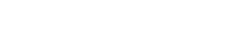

In [0]:
 sim = pd.DataFrame(columns=['Complements','Similarity Score'])
 sim.append({'Complements':1, 'Similarity Score':2}, ignore_index=True)
 sim.append({'Complements':2, 'Similarity Score':3}, ignore_index=True)

,Complements,Similarity Score
0,2,3


In [0]:
id = pid_to_idx['COLOR SAMPLE BM BASE1 PT']
print (id)
get_top_k(id,items,idx_to_pid,10)

469
Original Pdt- COLOR SAMPLE BM BASE1 PT

0.9780963 COLOR SAMPLE BM BASE2 PT
0.9656842 CEILING WB U-FLT WHT GL
0.9596774 REG SEL INT EGGSHL B1 GL
0.9542661 PAINTBRSH SLVRTP AS 1.5"
0.94405276 VT TITAN 2-1/2" SHRT CT TRIM BSH
0.93954414 1.5" PRO WEDGE NYLON/POLY BRUSH
0.9235729 VELVET TOUCH 9X3/8"LINT FREE REF
0.9205388 1.5" ANGL SASH BRSH PET BLEND
0.92028743 PAINTBRUSH FOAM 2" 8PACK
0.91948295 COLOR SAMPLE BM BASE3 PT


array([ 0.19158955,  0.4901167 ,  0.29657248, ...,  0.14614709,
       -0.42057133, -0.20583136], dtype=float32)

In [0]:
id = pid_to_idx['CARAMEL CREAMS 10 COUNT']
print (id)
get_top_k(id,items,idx_to_pid,10)

In [0]:
id = pid_to_idx['CARAMEL CREAMS 10 COUNT']
print (id)
get_top_k(id,items,idx_to_pid,10)

161
Original Pdt- CARAMEL CREAMS 10 COUNT

0.9862753 MRS FIELDS ICE CREAM SANDWICH
0.98238856 GREEN TEA 20OZ BOTTLE
0.98010284 GIANT ICE CREAM BAR
0.9776447 SOFT PPRMNT CNDYTUB/160
0.9743529 FILTER FURN 16X25X1" ACE
0.9698799 FILTER AIR PLEAT 16X25X1
0.96675575 BOTTLED WATER - SINGLE
0.9660673 12OZ CAN SODA
0.9657581 BOTTLED WATER 5 GAL/W BOTTLE EXC
0.96502703 6/6.5" POINSETTIA 3-4 BLOOM


array([-0.54886246,  0.03121768,  0.3772837 , ...,  0.1807538 ,
        0.10479502,  0.11298018], dtype=float32)

In [0]:
res = get_top_k( 6,items,idx_to_pid,5)

Original Pdt- POWERADE FRUIT PUNCH
0.98017925 SPRITE 20OZ
0.94044983 PRINGLES SC&O 5.57OZ
0.93751043 FUZE ICE TEA
0.928583 MINUTE MAID LEMONADE
0.9074397 BARQ'S ROOT BEER


In [0]:
get_top_k( 243,items,idx_to_pid,5)

Original Pdt- DIET COKE 20OZ
0.97446537 FANTA ORANGE
0.9319012 CANDY TWIZZLR STRW 7OZ
0.9296659 WATER
0.9269935 SEAGRAMS GINGER ALE
0.9253731 KIT KAT KING SIZE 3OZ


array([ 0.54229337, -0.26015273, -0.43606183, ...,  0.5518036 ,
       -0.20349571, -0.18817694], dtype=float32)

In [0]:
get_top_k( 5330,items,idx_to_pid,5)

Original Pdt- 1224419 $2 INST SAVINGS
0.88181645 PRIMR BULLS EYE WB GL
0.8698894 CAULK REMOVER TOOL
0.8679787 CNCV FOAM MINI 2PK 4"
0.86035156 STAIN MINWX8OZ SP WALNUT
0.8527403 1205137 $10 INST SAVINGS


array([-0.20533703,  0.6652015 ,  0.4011799 , ...,  0.02235771,
        0.02717717,  0.2063298 ], dtype=float32)

In [0]:
'''
243: 'DIET COKE 20OZ'
316: 'WATER JET NOZZLE'
395: 'NESTLE PURE LIFE 24PK.5L',
488: 'BLADE RAZOR #9 1EDGE10PK',
5339
'''

In [0]:
idx_to_pid

{0: 'CLEANR GLAS19OZ SPRAYWAY',
 1: 'SUPERHIDE LAT FLAT CEILWHITE  GL',
 2: 'SUPERHIDE LX PR/UN-WHITE GAL',
 3: 'PAINTBRSH SLVRTP AS 3"',
 4: 'PNTBRSH XL DALE 2.5"',
 5: '15A21/LED/2700K/120V/4PK',
 6: 'POWERADE FRUIT PUNCH',
 7: 'CMN Donations',
 8: 'FASTENERS',
 9: 'REGAL AQUAGLO WHITE',
 10: 'REG SEL INT EGGSHL B1 GL',
 11: '50% OFF 1 ITEM UNDER $30',
 12: '.5 MIL 9X12 DROP  5PK',
 13: 'TARP POLY BLUE/BRN 6X8',
 14: 'G-FORCE 10X12 BLUE TUFF TARPS',
 15: 'MSKG TAPE DEL 1.88x60',
 16: 'DUCT TAPE 60YDS GRAY ACE',
 17: 'PLSTC BUCKET 5G WHT ACE',
 18: 'CAULK DFLEX230 CLR10.1OZ',
 19: 'FUEL WOOD PELLETS 40#SKD',
 20: '8 PC SAWZALL BLADE SET',
 21: 'PUMP UTILITY 1/6HP ACE',
 22: 'RED BULL ENRGY DRNK 12OZ',
 23: 'CHEX TRADITIONAL SNACK',
 24: 'CREOSOTE SWEEPING LOG',
 25: 'CANDY ALMOND JOY 1.61OZ',
 26: 'G-FORCE 25X1 RUBBER GRIP TAPE ME',
 27: 'ACE 2 PC LOCKBACK KNIFE',
 28: 'REG SEL INT MATTE BS1 GL',
 29: 'REG SEL INT MATTE BS2 GL',
 30: 'REG SEL INT MATTE BS4 GL',
 31: 'REG SEL INT MATTE

## Visualization

In [0]:
import matplotlib.pyplot as plt


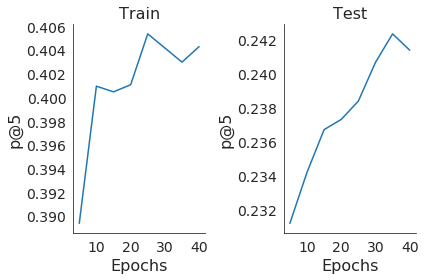

In [0]:
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=16);
    plt.xlabel('Epochs', fontsize=16);
    plt.ylabel('p@{}'.format(k), fontsize=16);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

## Parameter Tuning

In [0]:
! pip install scikit-optimize

     |████████████████████████████████| 81kB 3.8MB/s 


In [0]:
from skopt import forest_minimize

In [0]:
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=2019,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              train_interactions=None,
                                              k=5, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [0]:
space = [(1, 260), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=250,
                     random_state=0,
                     verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 105.6914
Function value obtained: -0.0095
Current minimum: -0.0095
Iteration No: 2 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.0740
Function value obtained: -0.2534
Current minimum: -0.2534
Iteration No: 3 started. Evaluating function at random point.
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epo

KeyboardInterrupt: ignored

In [0]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))